#  Graduate Admissions

## Data pre-processing and exploratory analysis

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

### Importing data

In [2]:
data_source = "./data/Admission_Predict_Ver1.1.csv"
df = pd.read_csv(data_source)

### Getting to know data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
Serial No.           500 non-null int64
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(5)
memory usage: 35.2 KB


In [4]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [5]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


### Features
- gre_score
- toefl_score
- university_rating
- sop
- lor
- cgpa
- research

### Target
- chance_of_admit

In [6]:
# Renaming columns
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace(" ", "_")
df = df.rename(index=str, columns={"lor_": "lor", "chance_of_admit_": "chance_of_admit"});

In [7]:
#Dropping "serial_no." as it is not needed
df = df.drop(columns = ['serial_no.'])

In [8]:
df.head()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [9]:
df.to_pickle(r'./data/df.pkl')

## Exploratory data analysis

### Using a pairplot to visualize distribution of data and correlation among columns
- As we can see - toefl_score, gre_score and cgpa have linear relationship among themselves and with target chance_of_admit
- That means people who scored higher in gre, also scored higher in toefl and vice versa
- People with higher cgpa score higher in gre and toefl
- higher gre & toelf score means higher chance of admit

In [10]:
# sns.pairplot(df, hue = 'chance_of_admit') # uncommented to speed up compiling

### Correlation matrix
- Darker squares means higher correlation
- Best case scenario is having  many features having higher correlation with target, but lower correlation among themselves

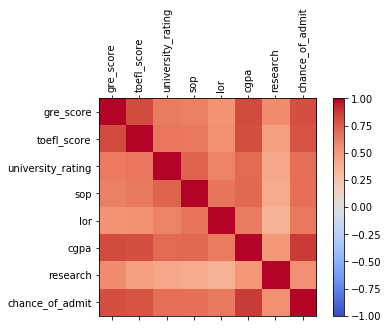

In [11]:
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

## Train-Test Split

Split data to independent variables matrix (X) and dependent variable vector (y)

In [12]:
X = df.iloc[:, :-1].values
y = df.iloc[:, 7].values

Split data 

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

A couple of utility functions to plot the results from each model.

In [32]:
def plot_histogram(y_true,y_pred):
    plt.figure(figsize=(12,4))
    y_true.hist(bins=22, normed=True)
    y_pred.hist(bins=22, normed=True, alpha=0.5)
    
    
def plot_best_fit(y_true, y_pred, model_name):
    plt.figure(figsize=(12,8))
#     reorder = y_true.sort.index.tolist()
#     x_series = np.array(y_true[reorder])
#     y_series = np.array(y_pred[reorder])    
    x_series = np.array(y_true)
    y_series = np.array(y_pred)
    
    # Create scatter plot of 
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.scatter(x_series, y_series, s=30, alpha=0.2, marker='o')

    # Create line of best fit and confidence intervals
    par = np.polyfit(x_series, y_series, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(x_series), max(x_series)]
    yl = [slope*x + intercept for x in xl]

    # Determine error bounds
    yerr = [abs(slope*xx + intercept - yy) for xx,yy in zip(x_series,y_series)]
    par = np.polyfit(x_series, yerr, 2, full=True)
    yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(x_series,y_series)]
    yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(x_series,y_series)]

    plt.plot(xl, yl, 'r')
    plt.plot(x_series, yerrLower, '--r')
    plt.plot(x_series, yerrUpper, '--r')

    plt.xlabel("Actual Admissions")
    plt.ylabel("{} Predictoins".format(model_name))    

# Modeling


## Linear Regression

In [33]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

X_train_lin_reg = X_train
y_train_lin_reg = y_train

Principal function that outputs the final optimized theta

In [34]:
def linear_regression(X, y, alpha, num_iters):
    n = X.shape[1]
    one_column = np.ones((X.shape[0],1))
    X = np.concatenate((one_column, X), axis = 1)
    # initializing the parameter vector...
    theta = np.zeros(n+1)
    # hypothesis calculation....
    h = hypothesis(theta, X, n)
    # returning the optimized parameters by Gradient Descent...
    theta, cost = gradient_descent(theta,alpha,num_iters,h,X,y,n)
    return theta, cost

Function that calculates and outputs the hypothesis value of the target variable

In [35]:
def hypothesis(theta, X, n):
    h = np.ones((X.shape[0],1))
    theta = theta.reshape(1,n+1)
    for i in range(0,X.shape[0]):
        h[i] = float(np.matmul(theta, X[i]))
    h = h.reshape(X.shape[0])
    return h

Function that performs the gradient descent algorithm

In [36]:
def gradient_descent(theta, alpha, num_iters, h, X, y, n):
    cost = np.ones(num_iters)
    for i in range(0,num_iters):
        theta[0] = theta[0] - (alpha/X.shape[0]) * sum(h - y)
        for j in range(1,n+1):
            theta[j] = theta[j] - (alpha/X.shape[0]) * sum((h-y) * X.transpose()[j])
        h = hypothesis(theta, X, n)
        cost[i] = (1/X.shape[0]) * 0.5 * sum(np.square(h - y))
    theta = theta.reshape(1,n+1)
    return theta, cost

Feature scaling

In [37]:
mean = np.ones(X_train_lin_reg.shape[1])
std = np.ones(X_train_lin_reg.shape[1])
for i in range(0, X_train_lin_reg.shape[1]):
    mean[i] = np.mean(X_train_lin_reg.transpose()[i])
    std[i] = np.std(X_train_lin_reg.transpose()[i])
    for j in range(0, X_train_lin_reg.shape[0]):
        X_train_lin_reg[j][i] = (X_train_lin_reg[j][i] - mean[i])/std[i]

Calling the principal function with learning_rate = 0.01

In [38]:
num_iters = 1000
theta, cost = linear_regression(X_train_lin_reg, y_train_lin_reg, 0.01, num_iters)

The reduction in the cost 

Text(0, 0.5, 'Cost')

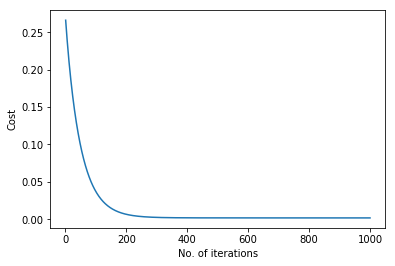

In [39]:
import matplotlib.pyplot as plt
cost = list(cost)
n_iterations = [x for x in range(1,num_iters+1)]
plt.plot(n_iterations, cost)
plt.xlabel('No. of iterations')
plt.ylabel('Cost')

Predictions:

In [40]:
# X_test = np.concatenate((np.ones((X_test.shape[0],1)), X_test) ,axis = 1)
# predictions_lin_reg = hypothesis(theta, X_test, X_test.shape[1] - 1)

Checking accurency

In [41]:
# accuracy_score(predictions_lin_reg, y_test)
# mean_absolute_error(predictions_lin_reg, y_test)

# print(predictions_lin_reg)
# print(y_test)
# print(X_test)

In [42]:
mean2 = np.ones(X_test.shape[1])
std2 = np.ones(X_test.shape[1])
for i in range(0, X_test.shape[1]):
    mean2[i] = np.mean(X_test.transpose()[i])
    std2[i] = np.std(X_test.transpose()[i])
    for j in range(0, X_test.shape[0]):
        X_test[j][i] = (X_test[j][i] - mean2[i])/std2[i]

In [43]:
X_test = np.concatenate((np.ones((X_test.shape[0],1)), X_test) ,axis = 1)
predictions_lin_reg = hypothesis(theta, X_test, X_test.shape[1] - 1)

ValueError: cannot reshape array of size 8 into shape (1,9)

In [44]:
# accuracy_score(y_test, predictions_lin_reg)     # getting errors TODO
# mean_absolute_error(predictions_lin_reg, y_test)

In [45]:
# print(y_test)

In [46]:
# print(predictions_lin_reg)

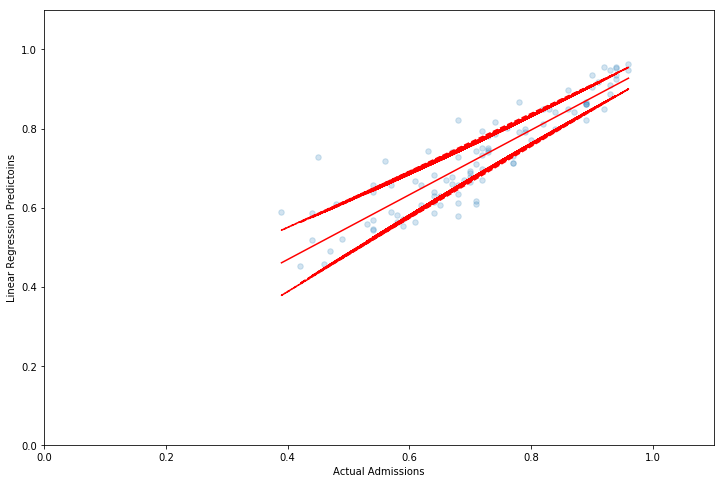

In [47]:
plot_best_fit(y_test, predictions_lin_reg, 'Linear Regression') # getting errors TODO

Test accurency:

In [30]:
output_error = y_test - predictions_lin_reg

error_lin_reg = np.mean(np.abs(output_error))
accuracy_lin_reg = (1 - error_lin_reg) * 100

print("Test Accuracy " + str(round(accuracy_lin_reg,2)) + "%")

Test Accuracy 95.75%


Save results to csv file

In [31]:
output_col_order = ['Chance of Admit', 'Predicted', 'Delta']
result_lin_reg = pd.DataFrame({'Chance of Admit':y_test,
                               'Predicted':predictions_lin_reg,
                               'Delta':(y_test - predictions_lin_reg)})
                        
result_lin_reg[output_col_order].to_csv('LR.csv', index=False)